In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:0')
print(device)

cuda:0


In [3]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [50, 150]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 5
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
        self.dict['training_data']['path'] = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
        self.dict['training_data']['data'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
        self.dict['training_data']['label_1'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x25000.npy'
        self.dict['training_data']['label_2'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 45
        self.dict['training_data']['limit'] = 50
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (135, 135)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.9, 1.0)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.5
        self.dict['architecture']['linear_shape'] = [256]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [4]:
par = Hyperparameter()

In [5]:
# Customized CNN model
class Net(Module):   
    def __init__(self, pretrained = False, dropout = 0.3, linear_shape = 512):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
#         self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 256, linear_shape)
        self.dropout = nn.Dropout(p = dropout)
        self.fc2 = nn.Linear(linear_shape, 1)
    
    def lock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = False
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
        self.fc2.weight.requires_grad = True
        self.fc2.bias.requires_grad = True
    
    def unlock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = True
            
    def load_pretrained(self):
        print("Loading weights and bias from VGG16.")
        vgg16 = torchvision.models.vgg16(pretrained = True)
        self.conv1.weight.data = vgg16.features[0].weight.data.to(device = device)
        self.conv1.bias.data = vgg16.features[0].bias.data.to(device = device)
        self.conv2.weight.data = vgg16.features[2].weight.data.to(device = device)
        self.conv2.bias.data = vgg16.features[2].bias.data.to(device = device)
        self.conv3.weight.data = vgg16.features[5].weight.data.to(device = device)
        self.conv3.bias.data = vgg16.features[5].bias.data.to(device = device)
        self.conv4.weight.data = vgg16.features[7].weight.data.to(device = device)
        self.conv4.bias.data = vgg16.features[7].bias.data.to(device = device)
        self.conv5.weight.data = vgg16.features[10].weight.data.to(device = device)
        self.conv5.bias.data = vgg16.features[10].bias.data.to(device = device)
        self.conv6.weight.data = vgg16.features[12].weight.data.to(device = device)
        self.conv6.bias.data = vgg16.features[12].bias.data.to(device = device)
        self.conv7.weight.data = vgg16.features[14].weight.data.to(device = device)
        self.conv7.bias.data = vgg16.features[14].bias.data.to(device = device)
#         self.conv8.weight.data = vgg16.features[17].weight.data.to(device = device)
#         self.conv8.bias.data = vgg16.features[17].bias.data.to(device = device)
#         self.conv9.weight.data = vgg16.features[19].weight.data.to(device = device)
#         self.conv9.bias.data = vgg16.features[19].bias.data.to(device = device)
#         self.conv10.weight.data = vgg16.features[21].weight.data.to(device = device)
#         self.conv10.bias.data = vgg16.features[21].bias.data.to(device = device)
#         self.conv11.weight.data = vgg16.features[24].weight.data.to(device = device)
#         self.conv11.bias.data = vgg16.features[24].bias.data.to(device = device)
#         self.conv12.weight.data = vgg16.features[26].weight.data.to(device = device)
#         self.conv12.bias.data = vgg16.features[26].bias.data.to(device = device)
#         self.conv13.weight.data = vgg16.features[28].weight.data.to(device = device)
#         self.conv13.bias.data = vgg16.features[28].bias.data.to(device = device)
    
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv9(x))
#         x = F.relu(self.conv10(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))
#         x = F.relu(self.conv13(x))
#         x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

train_label = np.load(input_path + par.dict['training_data']['label_1'])
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + par.dict['training_data']['label_2'])
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25010, 128, 128)
(25010,)
(25010,)


In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [9]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [10]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [11]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        if par.dict['training_data']['aperture'] != 0:
            img = img * aperture_mask
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [12]:
transform = transforms.Compose(
        [
            transforms.Resize(par.dict['segmentation']['resize']),
            transforms.RandomRotation(90),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [13]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [14]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

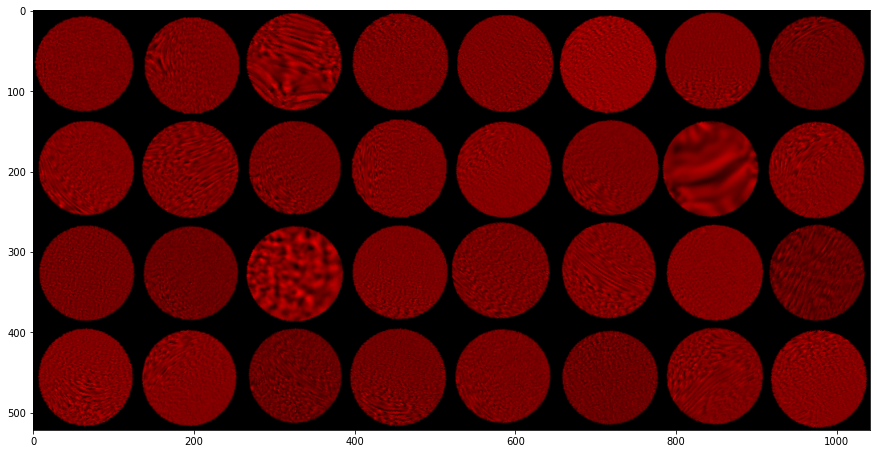

In [16]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.colorbar()
    plt.show()

fig = plt.figure(figsize = [15,9])
imshow(torchvision.utils.make_grid(images))

In [17]:
# Call the CNN model and start training
model = Net(dropout = par.dict['architecture']['dropout'], linear_shape = par.dict['architecture']['linear_shape'][0]).to(device)
model.load_pretrained()
model.lock_base()
criterion = nn.MSELoss(reduction = 'mean')

Loading weights and bias from VGG16.


In [18]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [19]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [20]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , float(val_acc), epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


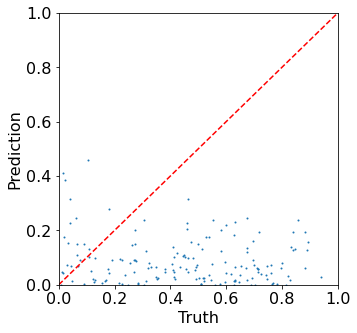

Epoch [0/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:41<00:00, 15.25it/s, loss=0.0323]


Training acc: 0.158517, Validation accuracy 0.981249


Epoch [1/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.48it/s, loss=0.0352]


Training acc: 0.042768, Validation accuracy 0.981249


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


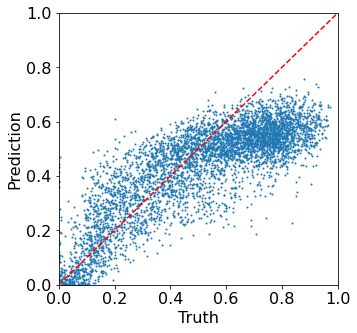

Epoch [2/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.59it/s, loss=0.0576]


Training acc: 0.036264, Validation accuracy 0.027809


Epoch [3/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.56it/s, loss=0.0214]


Training acc: 0.032896, Validation accuracy 0.027809


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


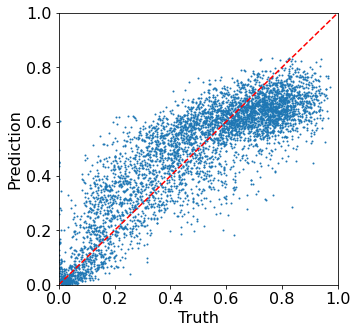

Epoch [4/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.64it/s, loss=0.0208]


Training acc: 0.031424, Validation accuracy 0.017803


Epoch [5/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.49it/s, loss=0.025]


Training acc: 0.030155, Validation accuracy 0.017803


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


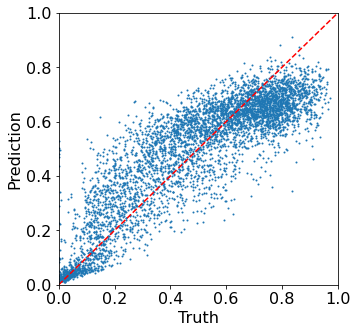

Epoch [6/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.59it/s, loss=0.0728]


Training acc: 0.029403, Validation accuracy 0.016751


Epoch [7/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.70it/s, loss=0.0177]


Training acc: 0.028378, Validation accuracy 0.016751


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


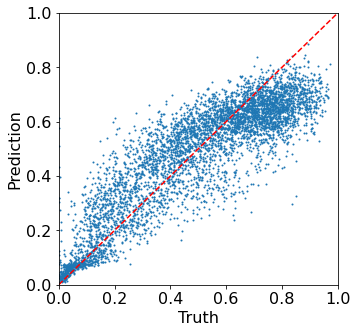

Epoch [8/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.54it/s, loss=0.046]


Training acc: 0.027665, Validation accuracy 0.016086


Epoch [9/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.69it/s, loss=0.0192]


Training acc: 0.026809, Validation accuracy 0.016086


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


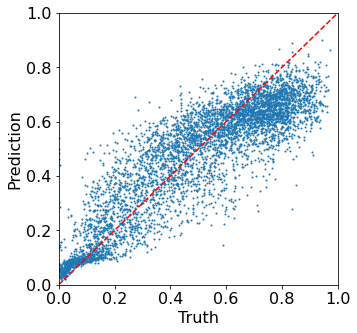

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.016114]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [10/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.65it/s, loss=0.0086]


Training acc: 0.026482, Validation accuracy 0.016114


Epoch [11/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.74it/s, loss=0.00249]


Training acc: 0.026113, Validation accuracy 0.016114


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


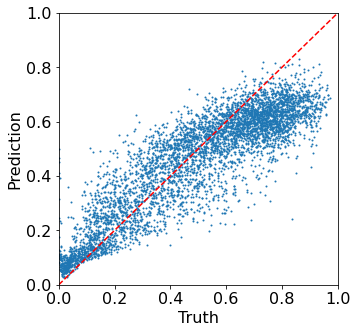

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.017642]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.46it/s, loss=0.0191]


Training acc: 0.025469, Validation accuracy 0.017642


Epoch [13/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.42it/s, loss=0.0409]


Training acc: 0.024885, Validation accuracy 0.017642


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


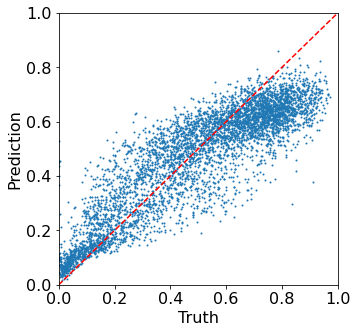

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.016572]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [14/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.64it/s, loss=0.00258]


Training acc: 0.024544, Validation accuracy 0.016572


Epoch [15/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.25it/s, loss=0.0382]


Training acc: 0.024595, Validation accuracy 0.016572


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


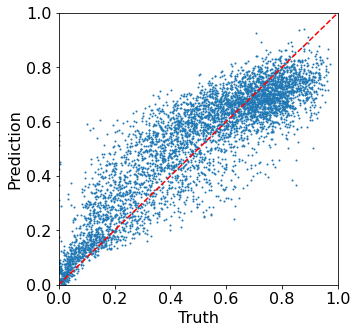

Epoch [16/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.53it/s, loss=0.0298]


Training acc: 0.024177, Validation accuracy 0.014975


Epoch [17/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.62it/s, loss=0.00776]


Training acc: 0.024033, Validation accuracy 0.014975


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


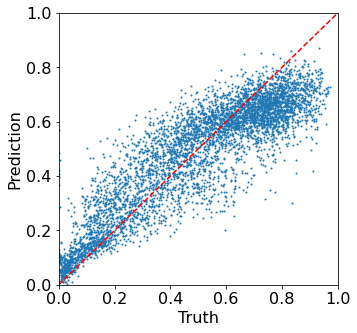

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.015277]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [18/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:39<00:00, 15.67it/s, loss=0.0188]


Training acc: 0.023219, Validation accuracy 0.015277


Epoch [19/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.71it/s, loss=0.0274]


Training acc: 0.023142, Validation accuracy 0.015277


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


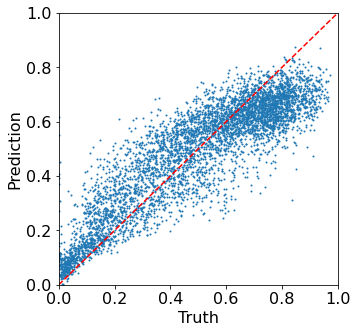

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.015219]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:39<00:00, 15.66it/s, loss=0.0389]


Training acc: 0.023075, Validation accuracy 0.015219


Epoch [21/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.44it/s, loss=0.0216]


Training acc: 0.022898, Validation accuracy 0.015219


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


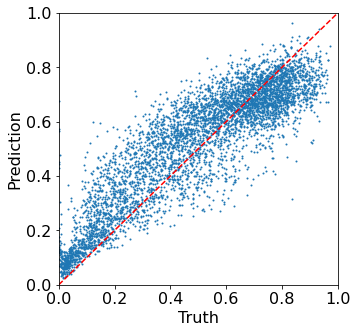

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.015097]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:39<00:00, 15.72it/s, loss=0.0303]


Training acc: 0.023021, Validation accuracy 0.015097


Epoch [23/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.61it/s, loss=0.0179]


Training acc: 0.022962, Validation accuracy 0.015097


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


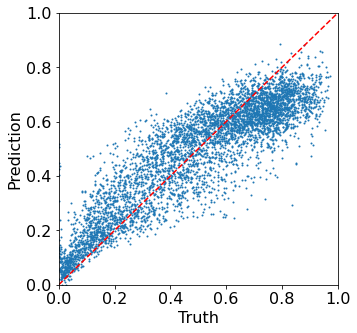

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.014884]

INFO: Early stopping counter 4 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:39<00:00, 15.68it/s, loss=0.0196]


Training acc: 0.022590, Validation accuracy 0.014884


Epoch [25/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.59it/s, loss=0.0117]


Training acc: 0.022312, Validation accuracy 0.014884


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


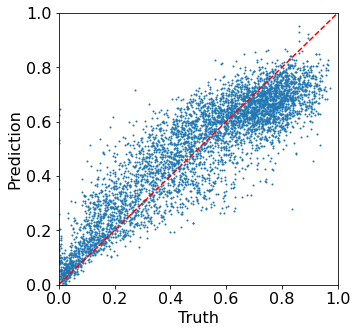

Epoch [26/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.59it/s, loss=0.0164]


Training acc: 0.022643, Validation accuracy 0.014172


Epoch [27/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.68it/s, loss=0.0154]


Training acc: 0.022459, Validation accuracy 0.014172


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


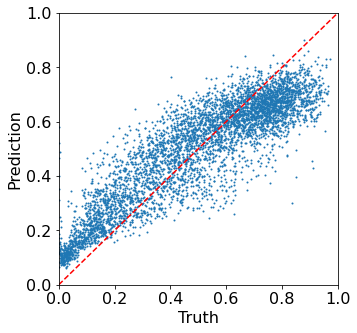

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.015607]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.50it/s, loss=0.032]


Training acc: 0.022669, Validation accuracy 0.015607


Epoch [29/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.31it/s, loss=0.0146]


Training acc: 0.022415, Validation accuracy 0.015607


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


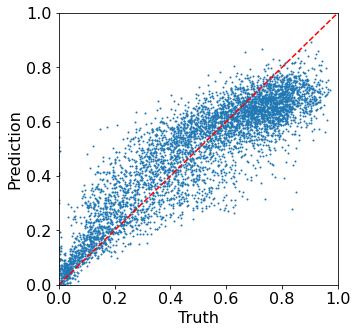

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.014719]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.39it/s, loss=0.038]


Training acc: 0.022390, Validation accuracy 0.014719


Epoch [31/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.67it/s, loss=0.0172]


Training acc: 0.022282, Validation accuracy 0.014719


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


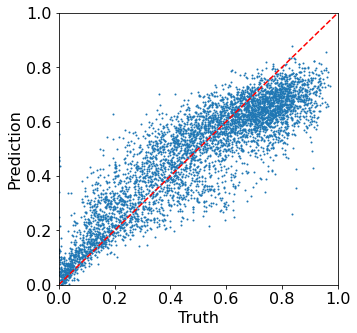

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.014898]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.57it/s, loss=0.00877]


Training acc: 0.022323, Validation accuracy 0.014898


Epoch [33/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:31<00:00, 19.58it/s, loss=0.0396]


Training acc: 0.022021, Validation accuracy 0.014898


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


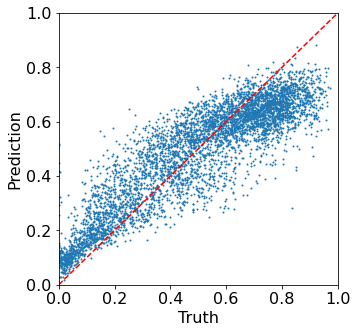

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.015377]

INFO: Early stopping counter 4 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:40<00:00, 15.53it/s, loss=0.0223]


Training acc: 0.022399, Validation accuracy 0.015377


Epoch [35/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:32<00:00, 19.53it/s, loss=0.0196]


Training acc: 0.022235, Validation accuracy 0.015377


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


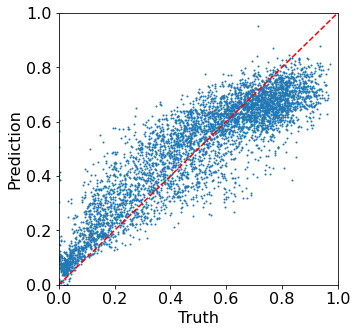

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.014268]

INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [21]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


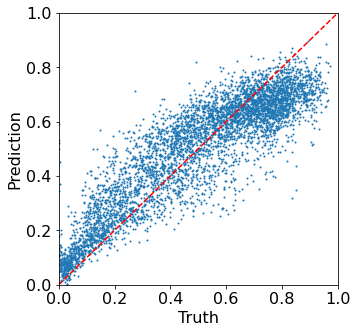

Epoch [0/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:28<00:00,  7.05it/s, loss=0.0269]


Training acc: 0.020465, Validation accuracy 0.014463


Epoch [1/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:20<00:00,  7.82it/s, loss=0.0196]


Training acc: 0.018817, Validation accuracy 0.014463


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


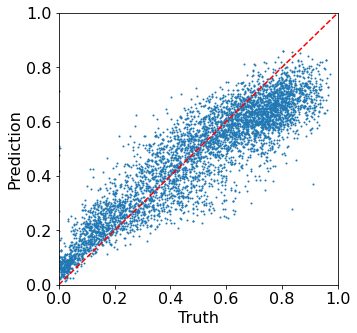

Epoch [2/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.13it/s, loss=0.0113]


Training acc: 0.018272, Validation accuracy 0.013809


Epoch [3/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.0305]


Training acc: 0.017315, Validation accuracy 0.013809


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


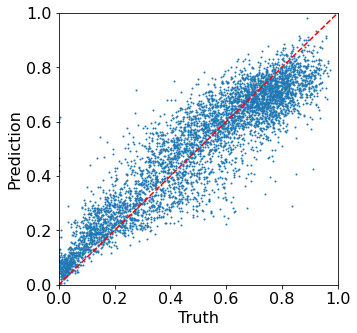

Epoch [4/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0149]


Training acc: 0.016993, Validation accuracy 0.010804


Epoch [5/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.89it/s, loss=0.0106]


Training acc: 0.016431, Validation accuracy 0.010804


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


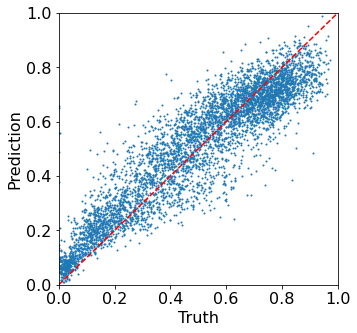

Epoch [6/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.00742]


Training acc: 0.016072, Validation accuracy 0.010464


Epoch [7/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0198]


Training acc: 0.015776, Validation accuracy 0.010464


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


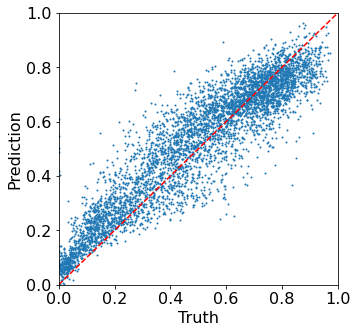

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.010468]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [8/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.18it/s, loss=0.00966]


Training acc: 0.015376, Validation accuracy 0.010468


Epoch [9/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.00403]


Training acc: 0.015284, Validation accuracy 0.010468


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


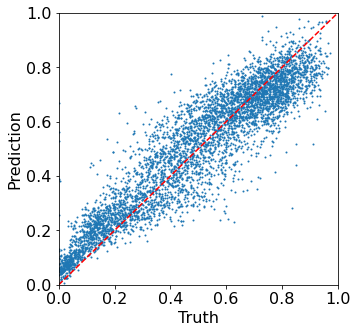

Epoch [10/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0246]


Training acc: 0.014821, Validation accuracy 0.009704


Epoch [11/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0158]


Training acc: 0.014839, Validation accuracy 0.009704


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


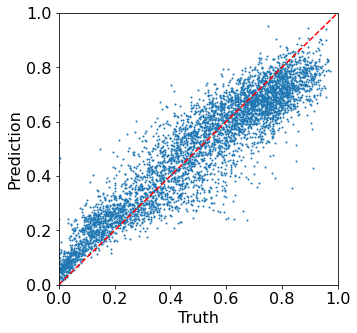

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.009764]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.017]


Training acc: 0.014703, Validation accuracy 0.009764


Epoch [13/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0192]


Training acc: 0.014379, Validation accuracy 0.009764


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


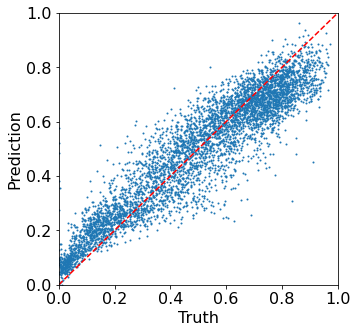

Epoch [14/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.00929]


Training acc: 0.014342, Validation accuracy 0.009430


Epoch [15/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0121]


Training acc: 0.014039, Validation accuracy 0.009430


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


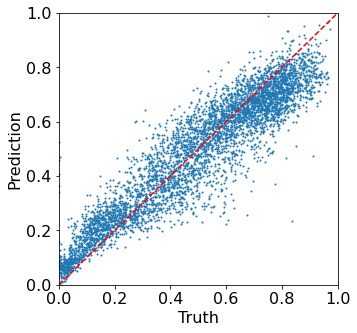

Epoch [16/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.0113]


Training acc: 0.014281, Validation accuracy 0.009025


Epoch [17/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0207]


Training acc: 0.013926, Validation accuracy 0.009025


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


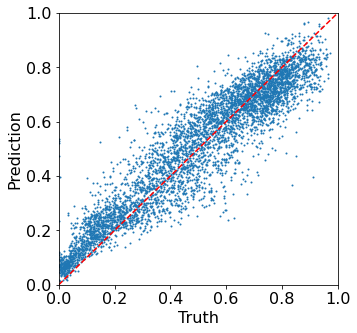

Epoch [18/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0218]


Training acc: 0.013836, Validation accuracy 0.008624


Epoch [19/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0194]


Training acc: 0.013773, Validation accuracy 0.008624


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


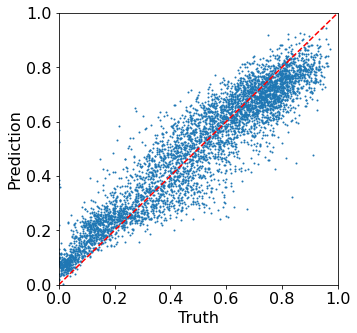

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.008628]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0233]


Training acc: 0.013463, Validation accuracy 0.008628


Epoch [21/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0118]


Training acc: 0.013457, Validation accuracy 0.008628


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


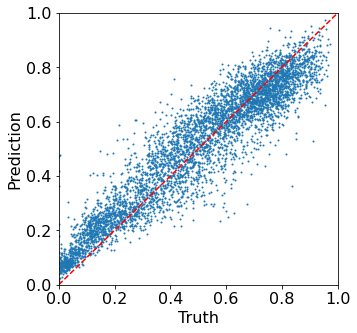

Epoch [22/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.0156]


Training acc: 0.013381, Validation accuracy 0.008401


Epoch [23/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0135]


Training acc: 0.013152, Validation accuracy 0.008401


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


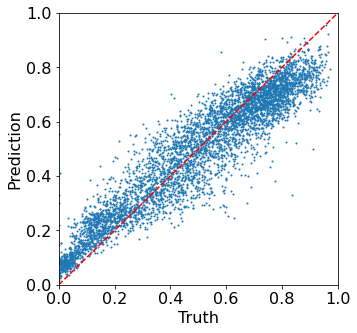

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.008675]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0118]


Training acc: 0.013250, Validation accuracy 0.008675


Epoch [25/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.00738]


Training acc: 0.012904, Validation accuracy 0.008675


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


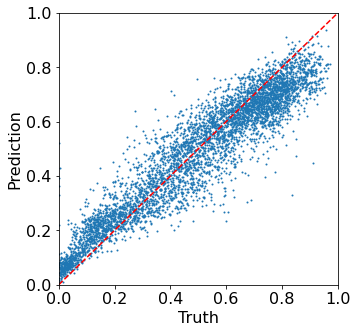

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.008334]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.18it/s, loss=0.0192]


Training acc: 0.012949, Validation accuracy 0.008334


Epoch [27/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.00859]


Training acc: 0.012648, Validation accuracy 0.008334


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


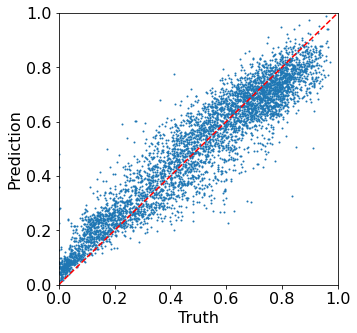

Epoch [28/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0183]


Training acc: 0.012649, Validation accuracy 0.007810


Epoch [29/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0133]


Training acc: 0.012610, Validation accuracy 0.007810


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


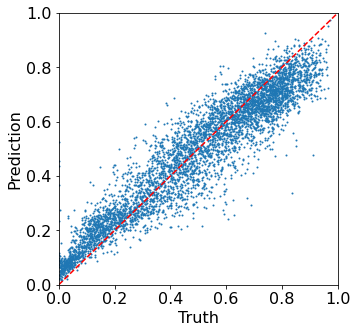

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.008041]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.18it/s, loss=0.0179]


Training acc: 0.012582, Validation accuracy 0.008041


Epoch [31/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.00896]


Training acc: 0.012400, Validation accuracy 0.008041


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


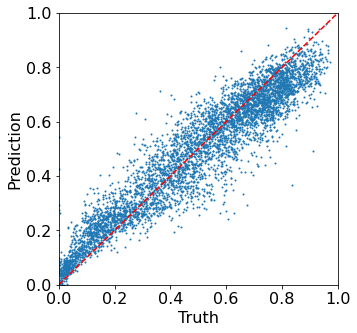

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007764]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.0129]


Training acc: 0.012323, Validation accuracy 0.007764


Epoch [33/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.89it/s, loss=0.0113]


Training acc: 0.012197, Validation accuracy 0.007764


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


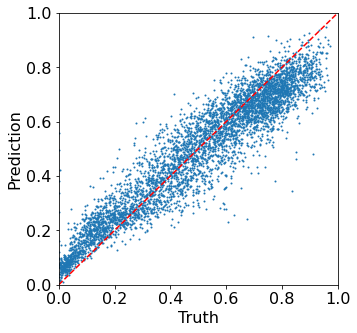

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.008067]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.00213]


Training acc: 0.012293, Validation accuracy 0.008067


Epoch [35/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.00967]


Training acc: 0.011959, Validation accuracy 0.008067


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


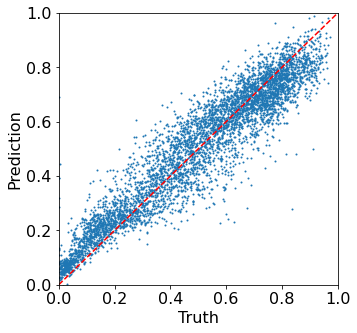

Epoch [36/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.0175]


Training acc: 0.011941, Validation accuracy 0.007396


Epoch [37/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0125]


Training acc: 0.011774, Validation accuracy 0.007396


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


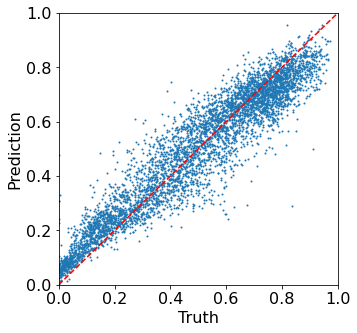

Epoch [38/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00408]


Training acc: 0.011624, Validation accuracy 0.007234


Epoch [39/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00457]


Training acc: 0.011771, Validation accuracy 0.007234


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


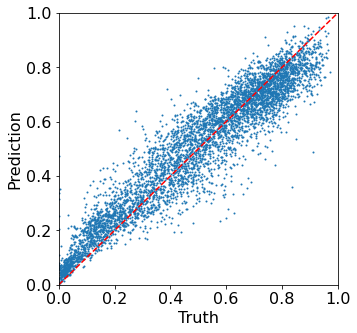

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007186]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0107]


Training acc: 0.011794, Validation accuracy 0.007186


Epoch [41/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.00612]


Training acc: 0.011752, Validation accuracy 0.007186


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


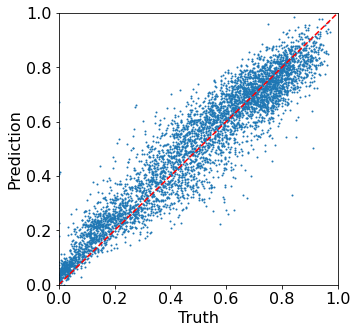

Epoch [42/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00904]


Training acc: 0.011686, Validation accuracy 0.007098


Epoch [43/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.00824]


Training acc: 0.011435, Validation accuracy 0.007098


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


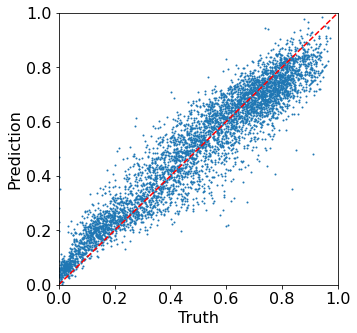

Epoch [44/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:28<00:00,  7.10it/s, loss=0.0111]


Training acc: 0.011513, Validation accuracy 0.006890


Epoch [45/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.84it/s, loss=0.0159]


Training acc: 0.011230, Validation accuracy 0.006890


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


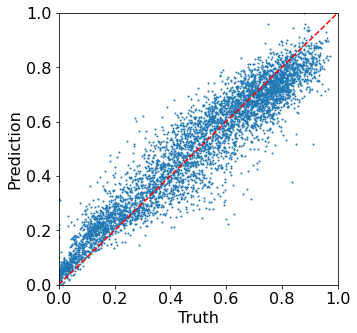

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007025]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [46/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.12it/s, loss=0.0135]


Training acc: 0.011416, Validation accuracy 0.007025


Epoch [47/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0122]


Training acc: 0.011130, Validation accuracy 0.007025


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


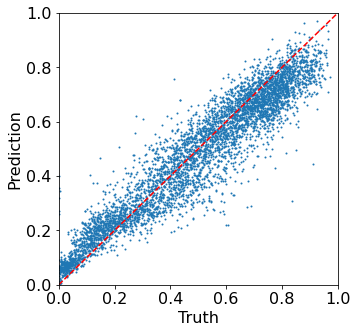

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007341]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [48/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0119]


Training acc: 0.011091, Validation accuracy 0.007341


Epoch [49/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.00872]


Training acc: 0.010965, Validation accuracy 0.007341


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


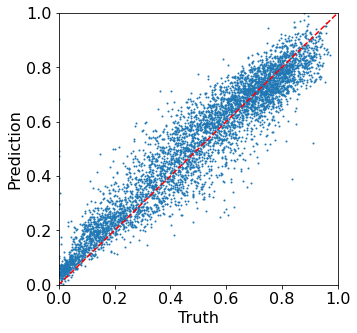

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.006984]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [50/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.00832]


Training acc: 0.010910, Validation accuracy 0.006984


Epoch [51/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.0193]


Training acc: 0.011023, Validation accuracy 0.006984


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


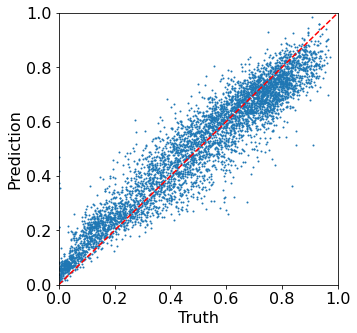

Epoch [52/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.0196]


Training acc: 0.010792, Validation accuracy 0.006755


Epoch [53/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0104]


Training acc: 0.010929, Validation accuracy 0.006755


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


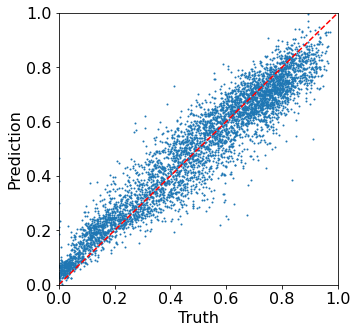

Epoch [54/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.13it/s, loss=0.00906]


Training acc: 0.010790, Validation accuracy 0.006561


Epoch [55/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00715]


Training acc: 0.010697, Validation accuracy 0.006561


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


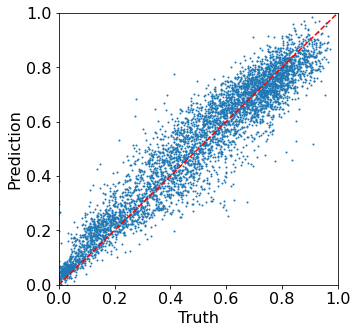

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006482]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [56/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0165]


Training acc: 0.010490, Validation accuracy 0.006482


Epoch [57/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.00541]


Training acc: 0.010480, Validation accuracy 0.006482


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


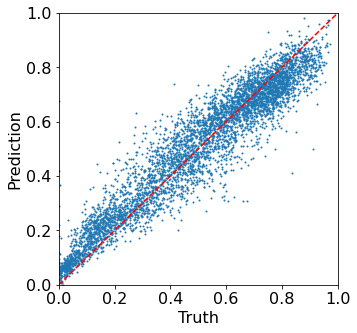

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006578]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [58/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00953]


Training acc: 0.010264, Validation accuracy 0.006578


Epoch [59/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0072]


Training acc: 0.010347, Validation accuracy 0.006578


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


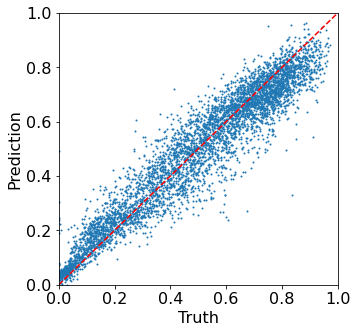

Epoch [60/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0113]


Training acc: 0.010264, Validation accuracy 0.006157


Epoch [61/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00559]


Training acc: 0.010232, Validation accuracy 0.006157


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


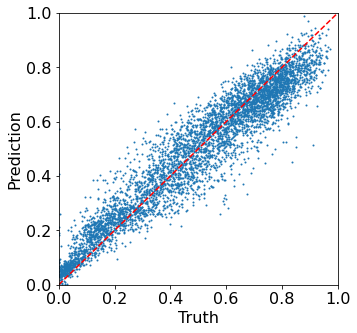

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006441]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [62/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.00748]


Training acc: 0.010233, Validation accuracy 0.006441


Epoch [63/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0246]


Training acc: 0.010256, Validation accuracy 0.006441


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


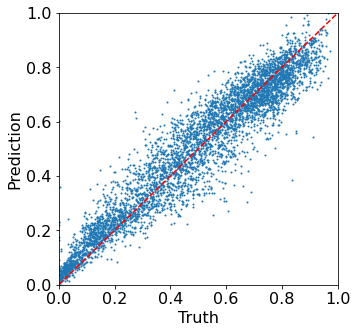

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006174]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [64/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.00933]


Training acc: 0.010012, Validation accuracy 0.006174


Epoch [65/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.89it/s, loss=0.0241]


Training acc: 0.010126, Validation accuracy 0.006174


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


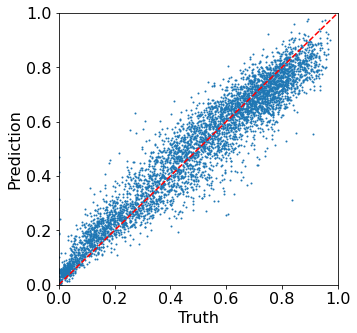

Epoch [66/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00853]


Training acc: 0.010158, Validation accuracy 0.005869


Epoch [67/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0114]


Training acc: 0.009838, Validation accuracy 0.005869


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


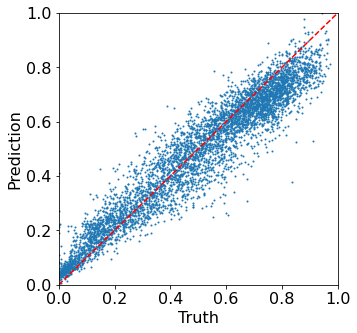

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.006531]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [68/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00758]


Training acc: 0.009928, Validation accuracy 0.006531


Epoch [69/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.0107]


Training acc: 0.010003, Validation accuracy 0.006531


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


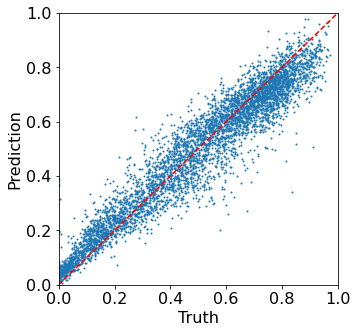

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005978]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [70/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.015]


Training acc: 0.009972, Validation accuracy 0.005978


Epoch [71/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.00655]


Training acc: 0.009830, Validation accuracy 0.005978


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


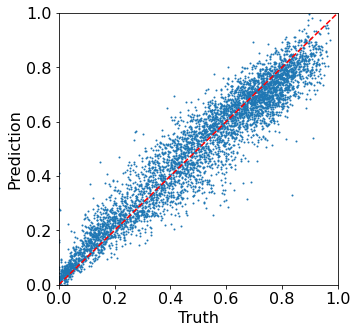

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005782]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [72/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.00811]


Training acc: 0.009761, Validation accuracy 0.005782


Epoch [73/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.00427]


Training acc: 0.009712, Validation accuracy 0.005782


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


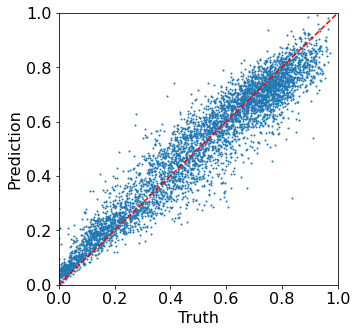

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005947]

INFO: Early stopping counter 4 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [74/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.00717]


Training acc: 0.009642, Validation accuracy 0.005947


Epoch [75/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00332]


Training acc: 0.009599, Validation accuracy 0.005947


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


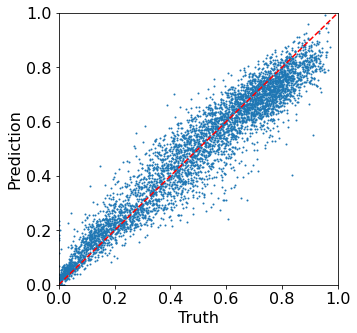

Epoch [76/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.013]


Training acc: 0.009515, Validation accuracy 0.005679


Epoch [77/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00647]


Training acc: 0.009639, Validation accuracy 0.005679


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


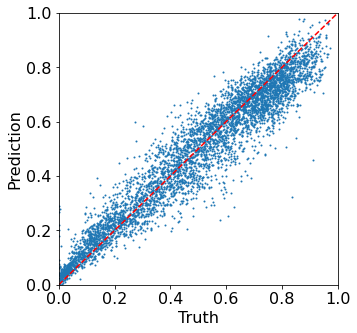

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005705]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [78/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.0049]


Training acc: 0.009354, Validation accuracy 0.005705


Epoch [79/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.86it/s, loss=0.0076]


Training acc: 0.009234, Validation accuracy 0.005705


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


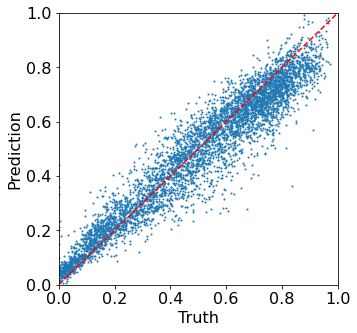

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006111]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [80/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00219]


Training acc: 0.009326, Validation accuracy 0.006111


Epoch [81/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.0128]


Training acc: 0.009302, Validation accuracy 0.006111


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


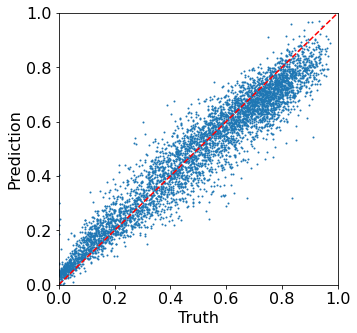

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005993]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [82/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.00852]


Training acc: 0.009304, Validation accuracy 0.005993


Epoch [83/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.00789]


Training acc: 0.009209, Validation accuracy 0.005993


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


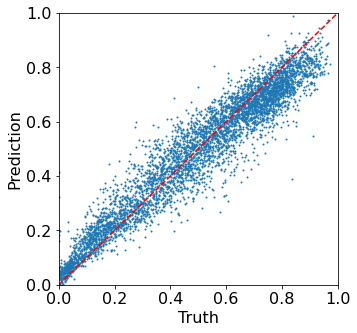

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005779]

INFO: Early stopping counter 4 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [84/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.00666]


Training acc: 0.009099, Validation accuracy 0.005779


Epoch [85/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0086]


Training acc: 0.009221, Validation accuracy 0.005779


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


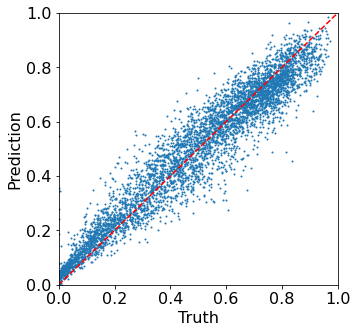

Epoch [86/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.18it/s, loss=0.00954]


Training acc: 0.009214, Validation accuracy 0.005487


Epoch [87/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.89it/s, loss=0.00276]


Training acc: 0.009011, Validation accuracy 0.005487


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


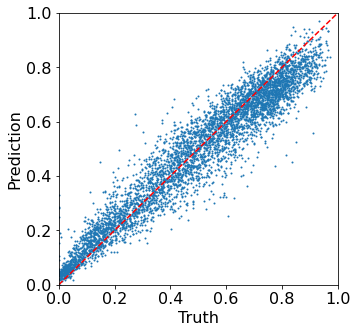

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005575]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [88/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.17it/s, loss=0.0109]


Training acc: 0.009102, Validation accuracy 0.005575


Epoch [89/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.89it/s, loss=0.00502]


Training acc: 0.008995, Validation accuracy 0.005575


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


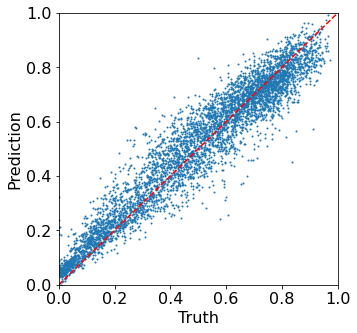

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005566]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [90/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.14it/s, loss=0.0118]


Training acc: 0.008974, Validation accuracy 0.005566


Epoch [91/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.84it/s, loss=0.0102]


Training acc: 0.009012, Validation accuracy 0.005566


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


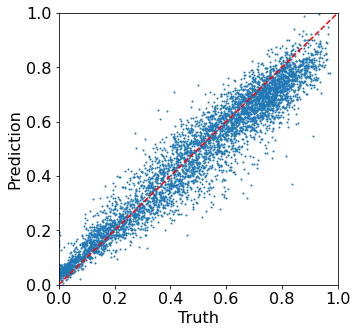

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005772]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [92/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.12it/s, loss=0.00447]


Training acc: 0.008788, Validation accuracy 0.005772


Epoch [93/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.84it/s, loss=0.0113]


Training acc: 0.008769, Validation accuracy 0.005772


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


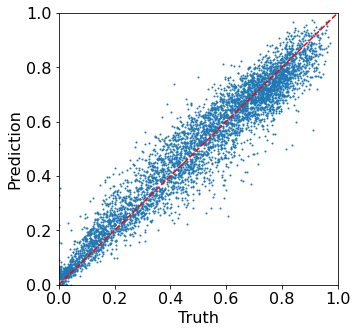

Epoch [94/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.0177]


Training acc: 0.008779, Validation accuracy 0.005241


Epoch [95/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.00382]


Training acc: 0.008812, Validation accuracy 0.005241


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


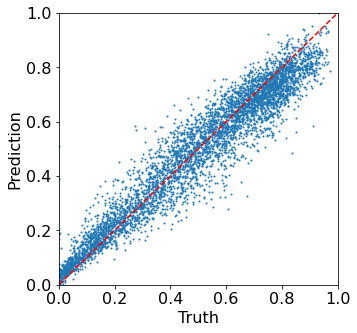

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005347]

INFO: Early stopping counter 1 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [96/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.00707]


Training acc: 0.008845, Validation accuracy 0.005347


Epoch [97/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.88it/s, loss=0.0108]


Training acc: 0.008714, Validation accuracy 0.005347


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


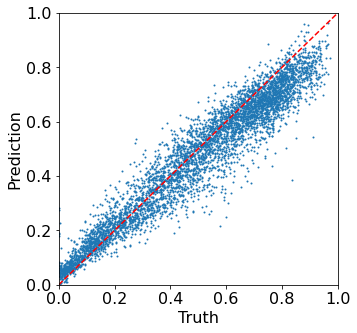

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.006147]

INFO: Early stopping counter 2 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [98/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.16it/s, loss=0.00503]


Training acc: 0.008570, Validation accuracy 0.006147


Epoch [99/150]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.87it/s, loss=0.0147]


Training acc: 0.008590, Validation accuracy 0.006147


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


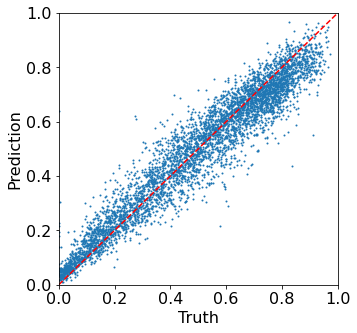

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005167]

INFO: Early stopping counter 3 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [100/150]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.15it/s, loss=0.01]


Training acc: 0.008640, Validation accuracy 0.005167


Epoch [101/150]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.00789]


Training acc: 0.008532, Validation accuracy 0.005167


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


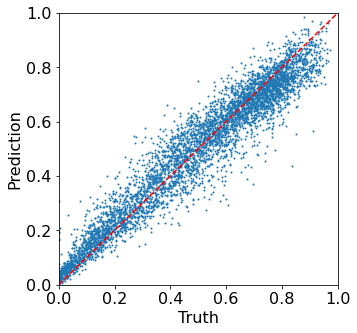

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005149]

INFO: Early stopping counter 4 of 5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [102/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:27<00:00,  7.13it/s, loss=0.0116]


Training acc: 0.008455, Validation accuracy 0.005149


Epoch [103/150]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [01:19<00:00,  7.85it/s, loss=0.0046]


Training acc: 0.008495, Validation accuracy 0.005149


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


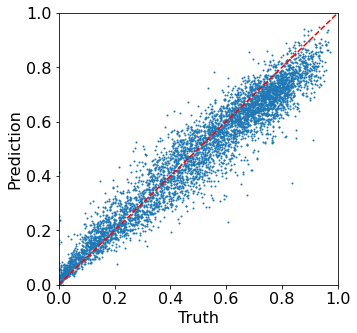

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.005823]

INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [22]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

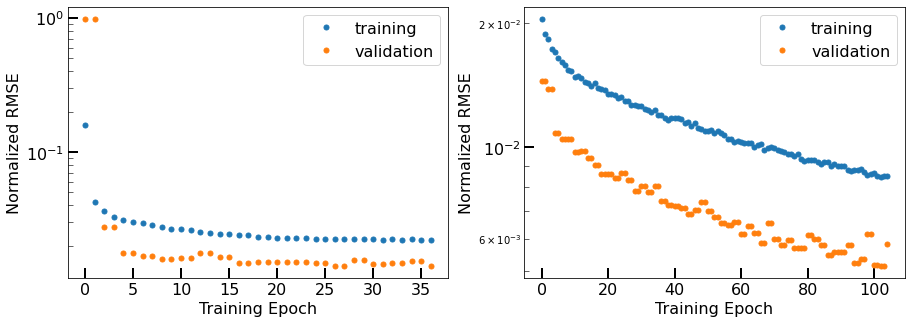

In [33]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(121)
ax.plot(np.array(par.process['training'][0]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][0], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

ax = fig.add_subplot(122)
ax.plot(np.array(par.process['training'][1]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][1], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

In [34]:
torch.save(model.state_dict(), 'TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt13.pt')
par.save_result('TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt13_')

In [35]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt13_hyperparameter.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [36]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt13_training_log.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [37]:
print(object_file['training'][0][-1])
print(object_file['validation'][0][-1])
print(object_file['training'][1][-1])
print(object_file['validation'][1][-1])

0.02223495
0.014268
0.008495139
0.005823


In [38]:
def scale_range_aperture_2(img, min, max):
    mask = aperture_generator(128, 50, 40)
    array = np.ndarray.flatten(img[np.where(mask==1)])
    img = img - np.amin(array)
    img = img / (np.amax(array) - np.amin(array))
    img = img * (max - min)
    img += min
    img[np.where(mask == 0)] = 0
    return img

In [39]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 1.5e-6, 1.5e-6, 3e-5, 3e-5, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]
abr_default = [2e-9, 2e-9, 2e-9, 20e-9, 20e-9, 20e-9, 20e-9, 0.5e-6, 1e-6, 1e-6, 1e-6, 1e-6]

In [40]:
abr_coeff = 'C1'
dwell_time = 250
path = '/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/'
# path = '/home/chenyu/Desktop/NionData/090221_50mrad_linescans/'
file_list = glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')
print(file_list)

['/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C12.x_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy', '/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C12.y_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy', '/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C10_2e-06m_100steps_250ms_bin1_repx5voaFOV.npy']


In [41]:
# ronch_list = np.load('NionRelated/C12.y_2e-06m_100steps_10ms_bin8.npy')
nsteps = 100
nrep = 5
x_list = []
y_list = []
t_list = []
coeff_list = []
x_default = [(abr_default[i] + abr_lim[i]/2) / abr_lim[i] for i in range(len(abr_list))]

for file in file_list:
    name_list = file.replace('/','_').split('_')
    print(file, name_list)
    abr_coeff = name_list[-6]
    idx = abr_list.index(abr_coeff)
    abr_range = abr_lim[idx]
    value_list = [(i - nsteps//2) * abr_range / nsteps for i in range(nsteps)]
    ronch_list = np.load(file)
    frame_list = []
    pred = []
    
    for i in range(nsteps):
        for j in range(nrep):
            x = [x_default[j] for j in range(len(x_default))]
            x[idx] = (value_list[i] + abr_range / 2) / abr_range
            x_list.append(x)
            frame = ronch_list[i * nrep + j,:,:]
            frame = scale_range_aperture_2(frame, 0, 1)
            new_channel = np.zeros(frame.shape)
            img_stack = np.dstack((frame, new_channel, new_channel))
            x = torch.tensor(np.transpose(img_stack)).to(device)
            x = x.unsqueeze(0).float()
            prediction = model(x)
            pred.append(prediction[0][0].cpu().detach().numpy())
            
    y_list.append(np.array(pred))
    t_list.append(name_list[-3])
    coeff_list.append(abr_coeff)

/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C12.x_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy ['', 'home', 'chenyu', 'Desktop', 'NionData', '090921', '250ms', 'linescan', 'Aligned', 'C12.x', '1.5e-06m', '100steps', '250ms', 'bin1', 'repx5voaFOV.npy']
/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C12.y_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy ['', 'home', 'chenyu', 'Desktop', 'NionData', '090921', '250ms', 'linescan', 'Aligned', 'C12.y', '1.5e-06m', '100steps', '250ms', 'bin1', 'repx5voaFOV.npy']
/home/chenyu/Desktop/NionData/090921/250ms_linescan_Aligned/C10_2e-06m_100steps_250ms_bin1_repx5voaFOV.npy ['', 'home', 'chenyu', 'Desktop', 'NionData', '090921', '250ms', 'linescan', 'Aligned', 'C10', '2e-06m', '100steps', '250ms', 'bin1', 'repx5voaFOV.npy']


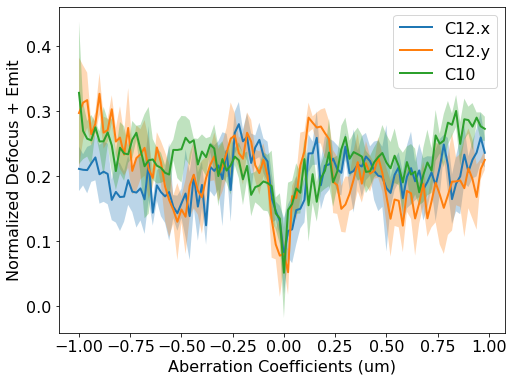

In [42]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
y_list_avg = []
x_list_avg = np.array(x_list[::5])
std_list = np.zeros(nsteps)

for i in range(len(t_list)):
    temp = y_list[i].reshape([nsteps, 5])
    y_list_avg.append(temp.mean(-1))
    for j in range(nsteps):
        std_list[j] = np.std(temp[j,:])
    p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = coeff_list[i])
#     p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = t_list[i])
#         p = ax.plot(temp.mean(-1), linewidth = 2, label = coeff_list[i])
    ax.fill_between(np.array(value_list) * 1e6, temp.mean(-1) - np.array(std_list), 
                    temp.mean(-1) + np.array(std_list), alpha = 0.3)

ax.set_xlabel('Aberration Coefficients (um)',fontsize = 16)
ax.set_ylabel('Normalized Defocus + Emit', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16)